In [52]:
import numpy as np
from osier import DispatchModel, LogicDispatchModel, CapacityExpansion
from osier import annual_emission, total_cost
from unyt import MW


import osier.tech_library as lib
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import time
import dill as pickle

from multiprocessing.pool import ThreadPool
from pymoo.core.problem import StarmapParallelization
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

In [45]:
lib.nuclear

Nuclear: 18609.404000000002 MW

In [2]:
with open("../time_data_dict.pkl", "rb") as f:
    time_data_dict = pickle.load(f)

In [5]:
time_data_dict['n_days'] = [1, 5, 10, 25, 50]

In [6]:
time_data_dict

{'n_days': [1, 5, 10, 25, 50],
 'solve_time_logical': [1.692204236984253,
  5.174538850784302,
  9.658742904663086,
  23.086899995803833,
  44.402994871139526],
 'solve_time_optimal': [68.47558999061584,
  76.13997173309326,
  84.86706590652466,
  110.15714526176453,
  150.65814304351807]}

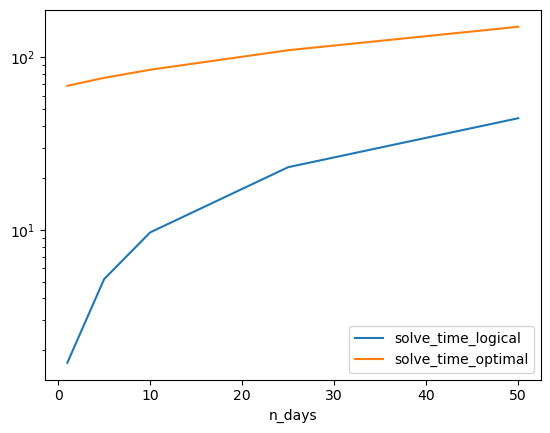

In [10]:
ax = pd.DataFrame(time_data_dict).plot(x='n_days')
ax.set_yscale('log')

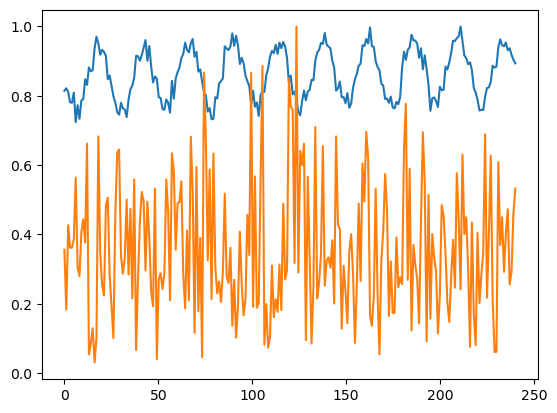

In [18]:
phase_shift = 0  # horizontal shift [radians]
base_shift = 2  # vertical shift [units of demand]
day_hours = 24  # hours per day
year_hours = 8760  # hours per year
total_demand = 185  # [MWh], sets the total demand [units of energy]
rng = np.random.default_rng(seed=1234)
squish = 0.5

n_days = 10  # days to model
N = day_hours * n_days  # total number of time steps

hours = np.linspace(0, N, N)
y = np.sin((hours * np.pi / year_hours + phase_shift)) + np.ones(len(hours)) * (base_shift + 1) * squish

demand = (np.sin((hours * np.pi / day_hours * 2 + phase_shift))
          * -1 + np.ones(N) * (base_shift + 1)) * 0.25 + y

noise = rng.normal(size=N)*0.05
demand += noise

demand = demand / demand.max()
wind_speed = rng.weibull(a=2, size=N)
wind_speed /= wind_speed.max()

plt.plot(hours, demand)
plt.plot(hours, wind_speed)

In [12]:
%%time
algorithm = NSGA2(pop_size=20)
problem = CapacityExpansion(technology_list = [lib.wind, lib.natural_gas, lib.battery],
                            demand=demand*MW,
                            wind=wind_speed,
                            upper_bound= 1 / lib.wind.capacity_credit,
                            objectives = [total_cost, annual_emission],
                            # model_engine='logical',
                            model_engine='optimal',
                            solver='appsi_highs',
                            )  # the objectives must be passed as a LIST of functions!

# define the problem by passing the starmap interface of the thread pool
# problem = MyProblem(elementwise_runner=runner)

res = minimize(problem, algorithm, termination=("n_gen", 10), seed=1, verbose=True, save_history=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      8 |             - |             -
     2 |       40 |      7 |  0.1841902220 |         nadir
     3 |       60 |      9 |  0.2734886643 |         ideal
     4 |       80 |      8 |  0.0039840007 |         ideal
     5 |      100 |     14 |  0.0511123078 |             f
     6 |      120 |     20 |  0.0309770309 |         ideal
     7 |      140 |     20 |  0.0350535586 |         ideal
     8 |      160 |     20 |  0.0046491063 |         ideal
     9 |      180 |     20 |  0.0056290621 |         ideal
    10 |      200 |     20 |  0.0375665456 |         ideal
CPU times: user 50.6 s, sys: 507 ms, total: 51.1 s
Wall time: 51 s


In [19]:
%%time
algorithm = NSGA2(pop_size=100)
problem = CapacityExpansion(technology_list = [lib.wind, lib.natural_gas, lib.battery],
                            demand=demand*MW,
                            wind=wind_speed,
                            upper_bound= 1 / lib.wind.capacity_credit,
                            objectives = [total_cost, annual_emission],
                            model_engine='logical',
                            # model_engine='optimal',
                            solver='appsi_highs',
                            )  # the objectives must be passed as a LIST of functions!

# define the problem by passing the starmap interface of the thread pool
# problem = MyProblem(elementwise_runner=runner)

res = minimize(problem, algorithm, termination=("n_gen", 10), seed=1, verbose=True, save_history=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     14 |             - |             -
     2 |      200 |     14 |  0.0370063934 |         ideal
     3 |      300 |     20 |  0.1471135963 |         ideal
     4 |      400 |     29 |  0.3728671066 |         nadir
     5 |      500 |     34 |  0.0046947306 |         ideal
     6 |      600 |     48 |  0.0292327665 |         ideal
     7 |      700 |     61 |  0.0062593311 |             f
     8 |      800 |     60 |  0.0064884558 |         ideal
     9 |      900 |     72 |  0.0046988141 |             f
    10 |     1000 |     83 |  0.0528731445 |         nadir
CPU times: user 42.9 s, sys: 275 ms, total: 43.1 s
Wall time: 43.2 s


In [ ]:
%%time
# initialize the thread pool and create the runner
n_threads = 1
pool = ThreadPool(n_threads)
runner = StarmapParallelization(pool.starmap)
algorithm = NSGA2(pop_size=100)
problem = CapacityExpansion(technology_list = [lib.wind, lib.natural_gas, lib.battery],
                            demand=demand*MW,
                            wind=wind_speed,
                            upper_bound= 1 / lib.wind.capacity_credit,
                            objectives = [total_cost, annual_emission],
                            model_engine='logical',
                            solver='appsi_highs',
                            elementwise_runner=runner)  # the objectives must be passed as a LIST of functions!

# define the problem by passing the starmap interface of the thread pool
# problem = MyProblem(elementwise_runner=runner)

res = minimize(problem, algorithm, termination=("n_gen", 10), seed=1, verbose=True, save_history=True)
print('Threads:', res.exec_time)

pool.close()

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     14 |             - |             -
     2 |      200 |     14 |  0.0370063934 |         ideal
     3 |      300 |     20 |  0.1471135963 |         ideal
     4 |      400 |     29 |  0.3728671066 |         nadir
     5 |      500 |     34 |  0.0046947306 |         ideal
     6 |      600 |     48 |  0.0292327665 |         ideal
     7 |      700 |     61 |  0.0062593311 |             f
     8 |      800 |     60 |  0.0064884558 |         ideal
     9 |      900 |     72 |  0.0046988141 |             f
    10 |     1000 |     83 |  0.0528731445 |         nadir
Threads: 44.171205043792725
CPU times: user 43.9 s, sys: 273 ms, total: 44.2 s
Wall time: 44.2 s


In [26]:
%%time
# initialize the thread pool and create the runner
n_threads = 2
pool = ThreadPool(n_threads)
runner = StarmapParallelization(pool.starmap)
algorithm = NSGA2(pop_size=100)
problem = CapacityExpansion(technology_list = [lib.wind, lib.natural_gas, lib.battery],
                            demand=demand*MW,
                            wind=wind_speed,
                            upper_bound= 1 / lib.wind.capacity_credit,
                            objectives = [total_cost, annual_emission],
                            model_engine='logical',
                            solver='appsi_highs',
                            elementwise_runner=runner)  # the objectives must be passed as a LIST of functions!

# define the problem by passing the starmap interface of the thread pool
# problem = MyProblem(elementwise_runner=runner)

res = minimize(problem, algorithm, termination=("n_gen", 10), seed=1, verbose=True, save_history=True)
print('Threads:', res.exec_time)

pool.close()

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |    100 |             - |             -
     2 |      200 |      5 |  1.168114E+24 |         ideal
     3 |      300 |      8 |  0.0687680223 |             f
     4 |      400 |      5 |  0.1341125453 |         ideal
     5 |      500 |      5 |  0.000000E+00 |             f
     6 |      600 |      6 |  0.3124646411 |         ideal
     7 |      700 |      7 |  0.0115584322 |         nadir
     8 |      800 |      7 |  0.000000E+00 |             f
     9 |      900 |      7 |  0.000000E+00 |             f
    10 |     1000 |      7 |  0.000000E+00 |             f
Threads: 37.40478587150574
CPU times: user 37.2 s, sys: 243 ms, total: 37.5 s
Wall time: 37.5 s


In [28]:
%%time
# initialize the thread pool and create the runner
n_threads = 4
pool = ThreadPool(n_threads)
runner = StarmapParallelization(pool.starmap)
algorithm = NSGA2(pop_size=100)
problem = CapacityExpansion(technology_list = [lib.wind, lib.natural_gas, lib.battery],
                            demand=demand*MW,
                            wind=wind_speed,
                            upper_bound= 1 / lib.wind.capacity_credit,
                            objectives = [total_cost, annual_emission],
                            model_engine='logical',
                            solver='appsi_highs',
                            elementwise_runner=runner)  # the objectives must be passed as a LIST of functions!

# define the problem by passing the starmap interface of the thread pool
# problem = MyProblem(elementwise_runner=runner)

res = minimize(problem, algorithm, termination=("n_gen", 10), seed=1, verbose=True, save_history=True)
print('Threads:', res.exec_time)

pool.close()

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |      1 |             - |             -
     2 |      200 |      2 |  6.0490697397 |         ideal
     3 |      300 |      4 |  0.9774145029 |         ideal
     4 |      400 |      4 |  0.000000E+00 |             f
     5 |      500 |      4 |  0.000000E+00 |             f
     6 |      600 |      4 |  0.000000E+00 |             f
     7 |      700 |      5 |  0.2729591200 |         nadir
     8 |      800 |      6 |  0.1321833006 |         ideal
     9 |      900 |      6 |  0.000000E+00 |             f
    10 |     1000 |      6 |  0.000000E+00 |             f
Threads: 33.09146022796631
CPU times: user 33 s, sys: 251 ms, total: 33.2 s
Wall time: 33.2 s


In [29]:
%%time
# initialize the thread pool and create the runner
n_threads = 8
pool = ThreadPool(n_threads)
runner = StarmapParallelization(pool.starmap)
algorithm = NSGA2(pop_size=100)
problem = CapacityExpansion(technology_list = [lib.wind, lib.natural_gas, lib.battery],
                            demand=demand*MW,
                            wind=wind_speed,
                            upper_bound= 1 / lib.wind.capacity_credit,
                            objectives = [total_cost, annual_emission],
                            model_engine='logical',
                            solver='appsi_highs',
                            elementwise_runner=runner)  # the objectives must be passed as a LIST of functions!

# define the problem by passing the starmap interface of the thread pool
# problem = MyProblem(elementwise_runner=runner)

res = minimize(problem, algorithm, termination=("n_gen", 10), seed=1, verbose=True, save_history=True)
print('Threads:', res.exec_time)

pool.close()

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |    100 |             - |             -
     2 |      200 |    100 |  0.000000E+00 |             f
     3 |      300 |      1 |  1.000000E+20 |         ideal
     4 |      400 |      1 |  0.000000E+00 |             f
     5 |      500 |      1 |  0.000000E+00 |             f
     6 |      600 |      3 |  0.3891017294 |         ideal
     7 |      700 |      3 |  0.000000E+00 |             f
     8 |      800 |      3 |  0.000000E+00 |             f
     9 |      900 |      3 |  0.000000E+00 |             f
    10 |     1000 |      3 |  0.000000E+00 |             f
Threads: 40.83934712409973
CPU times: user 40.7 s, sys: 360 ms, total: 41 s
Wall time: 40.9 s


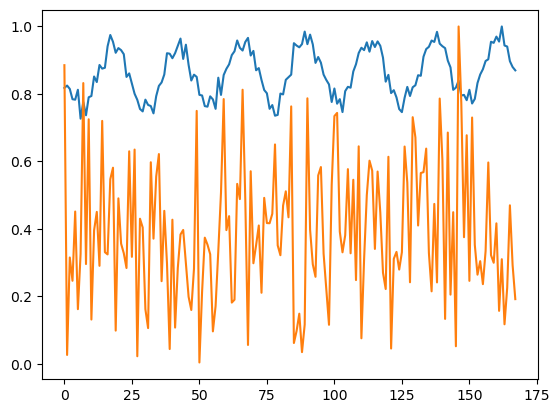

In [34]:
phase_shift = 0  # horizontal shift [radians]
base_shift = 2  # vertical shift [units of demand]
day_hours = 24  # hours per day
year_hours = 8760  # hours per year
total_demand = 185  # [MWh], sets the total demand [units of energy]
rng = np.random.default_rng(seed=1234)
squish = 0.5
n_days = 7

natural_gas = lib.natural_gas
# natural_gas.capacity = 
tech_list = [lib.wind, lib.natural_gas, lib.battery]

# synchronize the units
# synched_techs = synchronize_units(tech_list, MW, hour)

N = day_hours * n_days  # total number of time steps

hours = np.linspace(0, N, N)
y = np.sin((hours * np.pi / year_hours + phase_shift)) + np.ones(len(hours)) * (base_shift + 1) * squish

demand = (np.sin((hours * np.pi / day_hours * 2 + phase_shift))
        * -1 + np.ones(N) * (base_shift + 1)) * 0.25 + y

noise = rng.normal(size=N)*0.05
demand += noise

demand = demand / demand.max()
wind_speed = rng.weibull(a=2, size=N)
wind_speed /= wind_speed.max()

plt.plot(demand)
plt.plot(wind_speed)

In [57]:
opt_df = pd.read_csv("../../../data/full_dispatch_results_optimal.csv", index_col=0)
log_df = pd.read_csv("../../../data/full_dispatch_results_logic.csv", index_col=0)

In [58]:
opt_df.columns

Index(['NaturalGas_Conv', 'Nuclear', 'Battery', 'Curtailment',
       'Battery_charge', 'Battery_level', 'Cost', 'WindTurbine'],
      dtype='object')

In [59]:
log_df.columns

Index(['Battery', 'Battery_level', 'Battery_charge', 'Nuclear',
       'NaturalGas_Conv', 'Curtailment', 'LoadLoss', 'WindTurbine'],
      dtype='object')

In [66]:
cols = list(log_df.columns)
cols.remove('LoadLoss')
cols.remove("Battery_level")

In [67]:
cols

['Battery',
 'Battery_charge',
 'Nuclear',
 'NaturalGas_Conv',
 'Curtailment',
 'WindTurbine']

<Axes: >

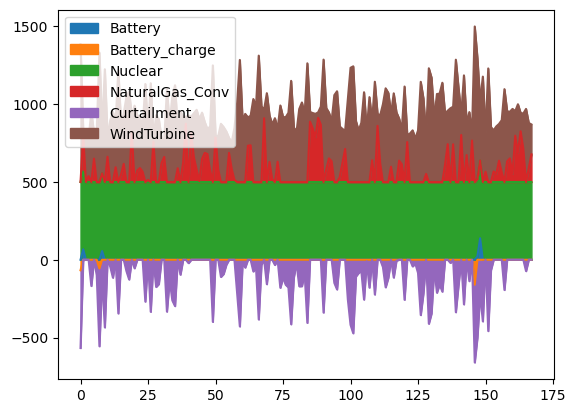

In [68]:
log_df[cols].plot.area()

<Axes: >

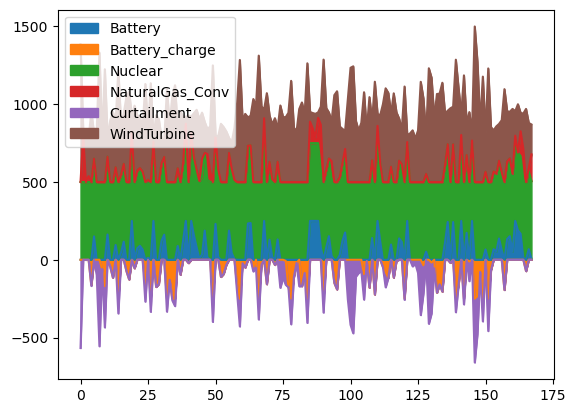

In [69]:
opt_df[cols].plot.area()

In [119]:
opt_subdf = opt_df[cols].copy()
log_subdf = log_df[cols].copy()

In [141]:
(log_subdf.sum(axis=0)).to_frame().columns

RangeIndex(start=0, stop=1, step=1)

In [156]:
opt_summed = opt_subdf.sum(axis=0).to_frame()
# opt_summed.columns = ['optimal']
display(opt_summed)
log_summed = log_subdf.sum(axis=0).to_frame()
# log_summed.columns = ['logic']
display(log_summed)

,0
Battery,9780.337465
Battery_charge,-9780.788358
Nuclear,84000.000000
NaturalGas_Conv,2955.640971
Curtailment,-7965.494410
WindTurbine,65822.903805


,0
Battery,283.900177
Battery_charge,-283.900177
Nuclear,84000.000000
NaturalGas_Conv,12668.582908
Curtailment,-17678.887241
WindTurbine,65822.903805


In [146]:
combined = pd.concat([opt_summed, log_summed], axis=1)
combined

,optimal,logic
Battery,9780.337465,283.900177
Battery_charge,-9780.788358,-283.900177
Nuclear,84000.000000,84000.000000
NaturalGas_Conv,2955.640971,12668.582908
Curtailment,-7965.494410,-17678.887241
WindTurbine,65822.903805,65822.903805


In [153]:
opt_summed - log_summed

,0
Battery,9496.437288
Battery_charge,-9496.888181
Nuclear,0.000000
NaturalGas_Conv,-9712.941937
Curtailment,9713.392830
WindTurbine,0.000000


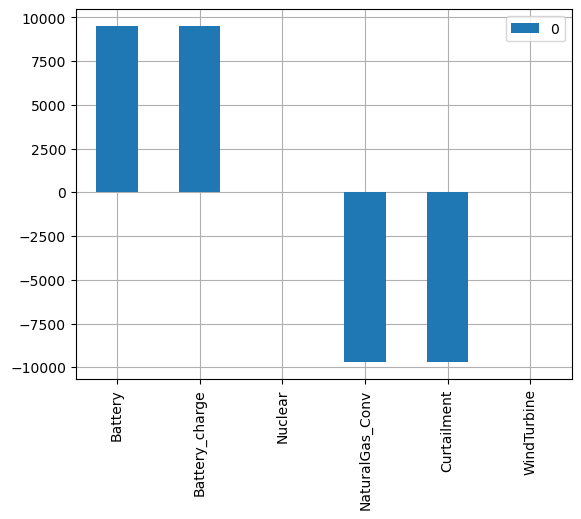

In [160]:
(opt_summed.abs() - log_summed.abs()).plot.bar(zorder=10)
plt.grid(zorder=0)

<Axes: >

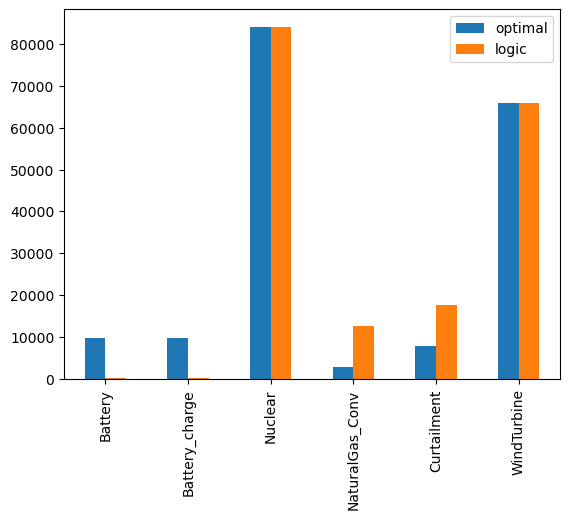

In [149]:
combined.abs().plot.bar()

In [ ]:
file_list = ["../../../data/gas_dispatch_results_logic.csv",
             "../../../data/gas_dispatch_results_optimal.csv",
             "../../../data/wind_dispatch_results_logic.csv",
             "../../../data/wind_dispatch_results_optimal.csv",
             "../../../data/full_dispatch_results_logic.csv",
             "../../../data/full_dispatch_results_optimal.csv"
             ]

In [53]:
time_df = pd.read_csv('../thread_data_out.csv', index_col=0)
time_df

,population,n_threads,solve_time
0,25,1,3.855529
1,25,2,3.920153
2,25,4,3.498557
3,25,8,3.914035
4,25,12,3.838676
5,50,1,8.018182
6,50,2,7.348753
7,50,4,6.897097
8,50,8,6.311177
9,50,12,6.881372


Text(0.5, 0, 'Population per Generation')

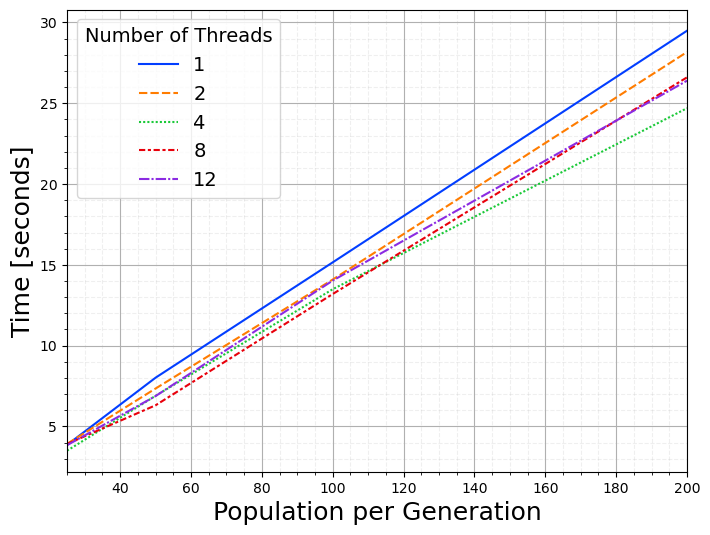

In [75]:
fig, ax = plt.subplots(figsize=(8,6))
sb.lineplot(time_df.loc[time_df['n_threads']<=12], 
            x='population',
            y='solve_time', 
            hue='n_threads', 
            ax=ax,
            palette="bright",
            style='n_threads')
# ax.set_yscale('log')
ax.legend(title="Number of Threads", fontsize=14, title_fontsize=14)
ax.minorticks_on()
ax.grid(which='major')
ax.grid(which='minor', linestyle='--', alpha=0.2)
ax.set_xlim(25,200)
ax.set_ylabel("Time [seconds]", fontsize=18)
ax.set_xlabel("Population per Generation", fontsize=18)


In [2]:
import pandas as pd

In [3]:
time_df_2 = pd.read_csv('../algorithm_out.csv', index_col=0)
time_df_2

,n_days,solve_time_logical,solve_time_optimal
0,1,1.723008,69.641030
1,5,5.213124,77.044488
2,10,9.615873,85.455327
3,25,22.970673,111.475247
4,50,44.495017,153.291478
5,100,84.576052,240.695931
6,200,173.831552,425.295289
7,300,261.837843,625.966045
8,365,311.887128,765.074678


In [8]:
(time_df_2['solve_time_optimal'] / time_df_2['solve_time_logical'])

0    40.418288
1    14.778948
2     8.886903
3     4.852938
4     3.445138
5     2.845911
6     2.446594
7     2.390663
8     2.453050
dtype: float64

<Axes: >

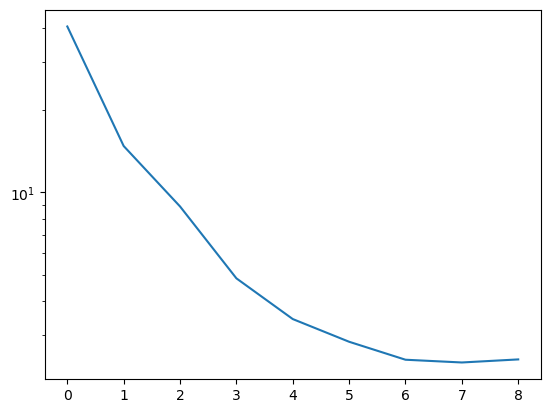

In [9]:
(time_df_2['solve_time_optimal'] / time_df_2['solve_time_logical']).plot(logy=True)

In [23]:
time_df_2.columns = ['n_days','logical dispatch', 'optimal dispatch']

In [42]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Number of Modeled Days')

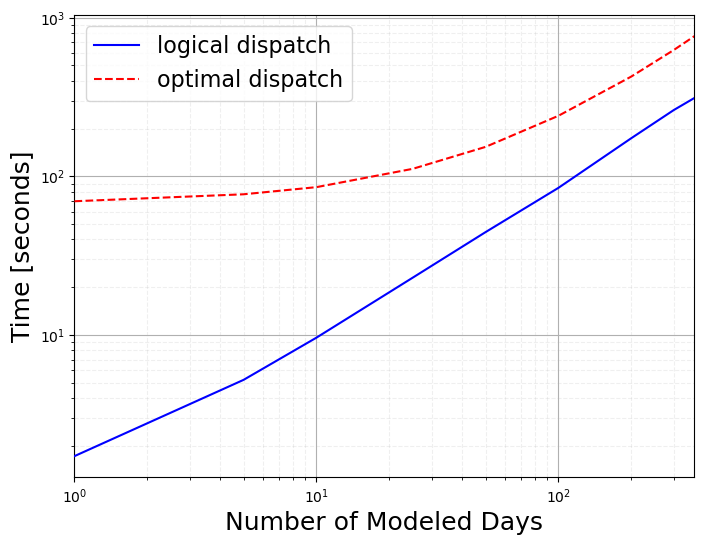

In [49]:
fig, ax = plt.subplots(figsize=(8,6))
time_df_2.plot(ax=ax, x='n_days', zorder=5, style={"logical dispatch":"b-",
                                                 "optimal dispatch":"r--"})
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(fontsize=16)
ax.minorticks_on()
ax.grid(which='major')
ax.grid(which='minor', linestyle='--', alpha=0.2)
ax.set_xlim(1,365)
ax.set_ylabel("Time [seconds]", fontsize=18)
ax.set_xlabel("Number of Modeled Days", fontsize=18)

# Example from Pymoo

In [6]:
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):

    def __init__(self, **kwargs):
        super().__init__(n_var=10, n_obj=1, n_ieq_constr=0, xl=-5, xu=5, **kwargs)

    def _evaluate(self, x, out, *args, **kwargs):
         out["F"] = (x ** 2).sum()

In [ ]:
from multiprocessing.pool import ThreadPool
from pymoo.core.problem import StarmapParallelization
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize


Threads: 0.5121731758117676


In [22]:
%%timeit
# initialize the thread pool and create the runner
n_threads = 4
pool = ThreadPool(n_threads)
runner = StarmapParallelization(pool.starmap)

# define the problem by passing the starmap interface of the thread pool
problem = MyProblem(elementwise_runner=runner)

res = minimize(problem, GA(), termination=("n_gen", 200), seed=1)
print('Threads:', res.exec_time)

pool.close()

Threads: 0.4878208637237549
Threads: 0.523719072341919
Threads: 0.47579097747802734
Threads: 0.5028600692749023
Threads: 0.5099411010742188
Threads: 0.47649407386779785
Threads: 0.49848389625549316
Threads: 0.4607880115509033
493 ms ± 20.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%%timeit
# initialize the thread pool and create the runner
n_threads = 1
pool = ThreadPool(n_threads)
runner = StarmapParallelization(pool.starmap)

# define the problem by passing the starmap interface of the thread pool
problem = MyProblem(elementwise_runner=runner)

res = minimize(problem, GA(), termination=("n_gen", 200), seed=1)
print('Threads:', res.exec_time)

pool.close()

Threads: 0.4913489818572998
Threads: 0.47499990463256836
Threads: 0.47937583923339844
Threads: 0.4685399532318115
Threads: 0.48570871353149414
Threads: 0.47326016426086426
Threads: 0.4649350643157959
Threads: 0.46422719955444336
474 ms ± 7.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
# initialize the thread pool and create the runner
n_threads = 10
pool = ThreadPool(n_threads)
runner = StarmapParallelization(pool.starmap)

# define the problem by passing the starmap interface of the thread pool
problem = MyProblem(elementwise_runner=runner)

res = minimize(problem, GA(), termination=("n_gen", 200), seed=1)
print('Threads:', res.exec_time)

pool.close()

Threads: 0.4878668785095215
Threads: 0.48943376541137695
Threads: 0.4685838222503662
Threads: 0.46479201316833496
Threads: 0.4653501510620117
Threads: 0.462252140045166
Threads: 0.46276092529296875
Threads: 0.45944666862487793
468 ms ± 9.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
%%timeit
# initialize the thread pool and create the runner
n_threads = 12
pool = ThreadPool(n_threads)
runner = StarmapParallelization(pool.starmap)

# define the problem by passing the starmap interface of the thread pool
problem = MyProblem(elementwise_runner=runner)

res = minimize(problem, GA(), termination=("n_gen", 200), seed=1)
print('Threads:', res.exec_time)

pool.close()

Threads: 0.48380017280578613
Threads: 0.5160937309265137
Threads: 0.47516703605651855
Threads: 0.4649639129638672
Threads: 0.4845540523529053
Threads: 0.4647958278656006
Threads: 0.46294116973876953
Threads: 0.4634408950805664
477 ms ± 17.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
import multiprocessing
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize


# initialize the thread pool and create the runner
n_proccess = 8
pool = multiprocessing.Pool(n_proccess)
runner = StarmapParallelization(pool.starmap)

# define the problem by passing the starmap interface of the thread pool
problem = MyProblem(elementwise_runner=runner)

res = minimize(problem, GA(), termination=("n_gen", 200), seed=1)
print('Threads:', res.exec_time)

pool.close()

KeyboardInterrupt: 